# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [4]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [5]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features,no_hidden[0]), 
            nn.ReLU(), #relu activation fn
            nn.Dropout(0.2),
            nn.Linear(no_hidden[0],no_hidden[1]), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden[1],no_hidden[2]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(no_hidden[2],no_labels),
            nn.Sigmoid()
        )
    # YOUR CODE HERE
    def forward(self,x):
        return self.mlp_stack(x)

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [7]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    # YOUR CODE HERE
    df.drop(columns=['filename'],inplace=True)
    X_train, y_train, X_test, y_test=split_dataset(df,columns_to_drop=['label'],test_size=0.3,random_state=42)
    X_train_scaled,X_test_scaled=preprocess_dataset(X_train,X_test)
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [4]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self,X,y):
        X=np.array(X,dtype=np.float32)
        y=np.array(y,dtype=np.float32)
        self.X=torch.from_numpy(X)
        self.y=torch.from_numpy(y)

    def __getitem__(self,index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)
    
def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    train_dataloader=DataLoader(CustomDataset(X_train_scaled,y_train),batch_size=256,shuffle=True)
    test_dataloader=DataLoader(CustomDataset(X_test_scaled,y_test),batch_size=256,shuffle=True)
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [5]:
# YOUR CODE HERE
no_features=len(df.columns)-1
no_hidden=[128,128,128]
no_labels=1

model=MLP(no_features,no_hidden,no_labels)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)  
loss_fn=nn.BCEWithLogitsLoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
# YOUR CODE HERE
from common_utils import EarlyStopper

train_accuracy=[]
test_accuracy=[]
train_loss=[]
test_loss=[]

early_stopper=EarlyStopper()

for epoch in range(100):
    overall_train_accuracy=0
    overall_train_loss=0

    model.train()
    for i,(x,y) in enumerate(train_dataloader):
        #forward pass
        pred=model(x)
        loss=loss_fn(pred.squeeze(),y)

        #backward pass and optimise
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        overall_train_loss+=loss.detach()
        overall_train_accuracy+=(pred.round().squeeze()==y).float().mean()

    avg_train_accuracy=overall_train_accuracy/len(train_dataloader)
    avg_train_loss=overall_train_loss/len(train_dataloader)

    train_accuracy.append(avg_train_accuracy)
    train_loss.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        #Test eval
        overall_test_loss=0
        overall_test_accuracy=0
        for x,y in test_dataloader:
            test_pred=model(x)
            overall_test_accuracy+=(test_pred.round().squeeze()==y).float().mean()
            overall_test_loss+=loss_fn(test_pred.squeeze(),y)

    avg_test_accuracy=overall_test_accuracy/len(test_dataloader)
    avg_test_loss=overall_test_loss/len(test_dataloader)

    test_accuracy.append(avg_test_accuracy)
    test_loss.append(avg_test_loss)

    #Early Stopping
    if early_stopper.early_stop(avg_test_loss):
        print(f'Early Stopping at epoch {epoch+1}')
        break

Early Stopping at epoch 16


#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


Text(0.5, 0, 'epoch')

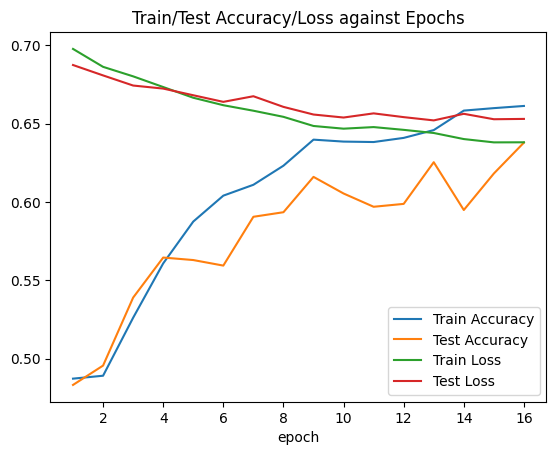

In [7]:
# YOUR CODE HERE
epochs=np.arange(1,epoch+2,1)

plt.figure()
plt.plot(epochs,train_accuracy,label='Train Accuracy')
plt.plot(epochs,test_accuracy,label='Test Accuracy')
plt.plot(epochs,train_loss,label='Train Loss')
plt.plot(epochs,test_loss,label='Test Loss')
plt.title('Train/Test Accuracy/Loss against Epochs')
plt.legend()
plt.xlabel('epoch')

2. Comment on line plots.

In [1]:
# YOUR CODE HERE
answer = '''During each epoch of training, the optimizer iteratively updates the model's parameters to minimize training loss
            within each mini-batch, allowing the model to make more generalized predictions.This continuous update of hyperparameters 
            causes a steady decrease in train and test loss while increasing in train and test accuracy across epochs. As the optimizer
            approaches convergence, overfitting starts to take place and and test loss starts to stabilize.
        '''